Avances de resultados estrategia para la localización Óptima de Sensores de Contaminación Lumínica

In [2]:
#!pip install scikit-image

In [3]:
from PIL import Image
                    
import numpy as np

#from noisyopt import minimizeCompass

from sortedcontainers import SortedList

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.pylab import rcParams
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib.patches as mpatches

from skimage.feature import peak_local_max

from skimage.segmentation import watershed

from scipy import ndimage as ndi

In [4]:
def f5(i,p,e=4):
    '''
    Pesos exponenciales
    
    W = i*a^(p-r)
    '''
    return i*e**(p)

def getN(W,i,j):
    ln = ([])
    c = W[i,j]
    ln.append(W[i+1,j])
    ln.append(W[i-1,j])
    ln.append(W[i-1,j-1])
    ln.append(W[i-1,j+1])
    ln.append(W[i+1,j+1])
    ln.append(W[i+1,j-1])
    ln.append(W[i,j+1])
    ln.append(W[i,j-1])
    opt = False if W[i,j]<max(ln) else True
    return opt

def fuerza_puntual(x,y,im2,h=2,e=2):
    '''
    this does not make sense if we have corrected verions solving the saturarion image problem
    
    '''
    s = 0.0 
    g1 = float(im2[x][y])
    xlb = 0 if(x-h)<0 else x-h
    xub = im2.shape[0] if(x+h)> im2.shape[0] else x+h
    
    ylb = 0 if(y-h)<0 else y-h
    yub = im2.shape[1] if(y+h)> (im2.shape[1]) else y+h 
    
    ri = np.arange(xlb,xub)
    rj = np.arange(ylb,yub)
    for i in ri:
        for j in rj:
            d=((i-x)**2+(j-y)**2)**(0.5)
            g2 = float(im2[i][j])
            if d >0: s += (g1*g2)/(d**e)
    return s

def filtro_fuerza_puntual(A,h=3,e=2):
    pot1 = np.zeros(A.shape)
    for i in range(pot1.shape[0]):
        for j in range(pot1.shape[1]):
            pot1[i][j] = fuerza_puntual(i,j,A,h,e)
            
    return pot1


def plot_examples(data,colormaps,filename):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    #fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=False, squeeze=False)
    fig, axs = plt.subplots(1, n, figsize=(6, 5.2),constrained_layout=False, squeeze=False)
   
    scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    for [ax, cmap] in zip(axs.flat, colormaps):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        psm = ax.pcolormesh(np.flip(data,0), cmap=cmap, rasterized=False, vmin=0, vmax=data.max())
        fig.colorbar(psm, ax=ax)
    
    

    plt.savefig(filename, dpi = 150)

def getMax(img):
    B = np.zeros(img.shape)
    for i in range(1,B.shape[0]-1):
        for j in range(1,B.shape[1]-1):
            B[i][j] = getN(img,i,j)
    
    positionsB = B*(img>0)
    locationsP = np.zeros(nonsat.shape)
    for i in range(0,nonsat.shape[0]):
        for j in range(0,nonsat.shape[1]):
            locationsP[i][j] = 8 if positionsB[i][j]==1 else P[i,j]
    
    
    return positionsB

def get_coords(seeds):
    coords = np.array([[0,0]])
    for i in range(0,seeds.shape[0]):
        for j in range(0,seeds.shape[1]):
            if seeds[i,j]!=0:
                coords = np.append(coords,[[i,j]],axis=0)
    return coords

custom_cmap = cm.get_cmap('hot', 256)
newcolors = custom_cmap(np.linspace(0, 1, 256))
pink = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

Carga de imágenes

In [18]:
#Original nocturnal image without values <21
im1 = np.array(Image.open('inputs/qro_light_th'))
im1 = np.where(im1==255, 0, im1) 

#Region priorities of Jorge and Lamphar
P = np.array(Image.open('inputs/prioridades'))

#calcular este valor automaticamente
nc = 5

# 0 máxima prioridad
# 4 mínima prioridad (antes espacio nan)
P = np.where(np.isnan(P),nc, P)-1 
P = P.max()-P


im1_gr = filtro_fuerza_puntual(im1,h=3,e=4)

W1 = f5(im1,P)
W2 = f5(im1_gr,P)


FileNotFoundError: [Errno 2] No such file or directory: 'inputs/qro_light_th'

# Transformada de la distancia en la región saturada. Usamos esta en vez de la transformación que nos inventamos

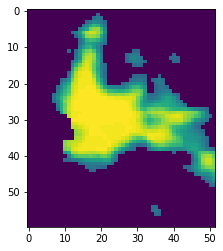

In [111]:

plt.imshow(im1)

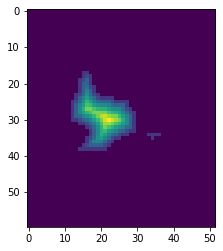

In [54]:
th = 62

image = im1>=th

distance = ndi.distance_transform_edt(image)

plt.imshow(distance)

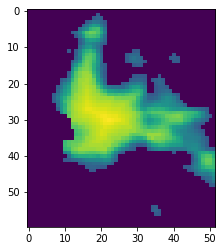

In [83]:
#Sustituimos la parte saturada en la imagen original.

nons = (im1>=th)*im1

nonsat = im1+(distance*2)
plt.imshow(nonsat)

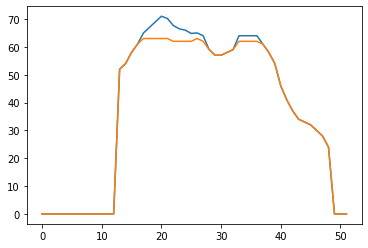

In [90]:
# Ejemplo Sección desaturada vs original saturada fila 34

plt.plot(nonsat[34,:])
plt.plot(im1[34,:])

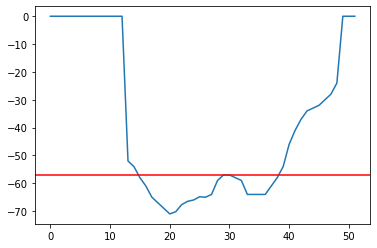

In [107]:
#  hacemos la analogia del mapa de NTI con la de una cuenca
plt.plot(-nonsat[34,:])
plt.axhline(y=-57, color='r', linestyle='-')

#plt.plot(-im1[34,:])

Identificar Picos de la imagen sin las clases P

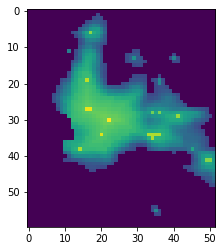

In [85]:
seeds = getMax(nonsat)
plt.imshow(seeds*20+nonsat)

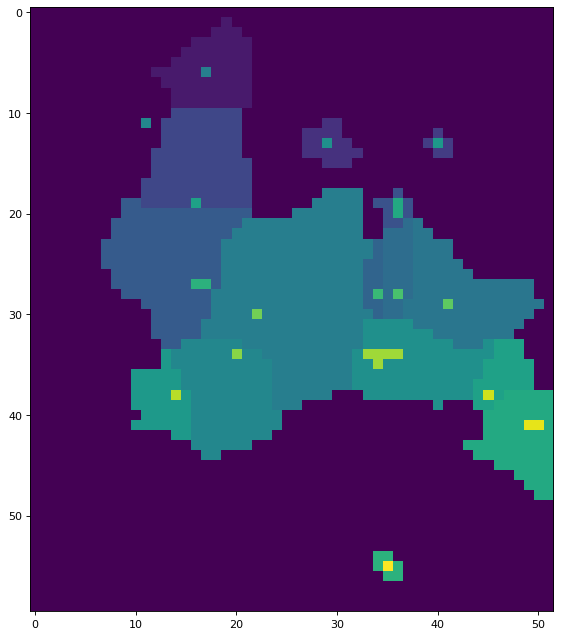

In [86]:
coords = get_coords(seeds) 

mask = np.zeros(im1.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers, _ = ndi.label(mask)
labels = watershed(-nonsat, markers, mask=im1)

figure(figsize=(10, 10), dpi=80)
plt.imshow(labels+seeds*10)

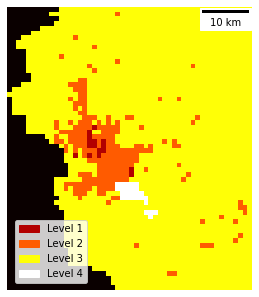

In [87]:
# Considerando la combinacion del mapa de NLTT y las clases P

data = P

# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(data.ravel())

plt.figure(figsize=(6, 5.2))
im = plt.imshow(data,cmap = plt.cm.hot)

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=int(values[i])) ) for i in range(1,5) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.33, 0.25), loc=1, borderaxespad=0.1 )
plt.axis('off')
scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

plt.savefig("figures/01_importance_level_map.pdf", dpi = 150)

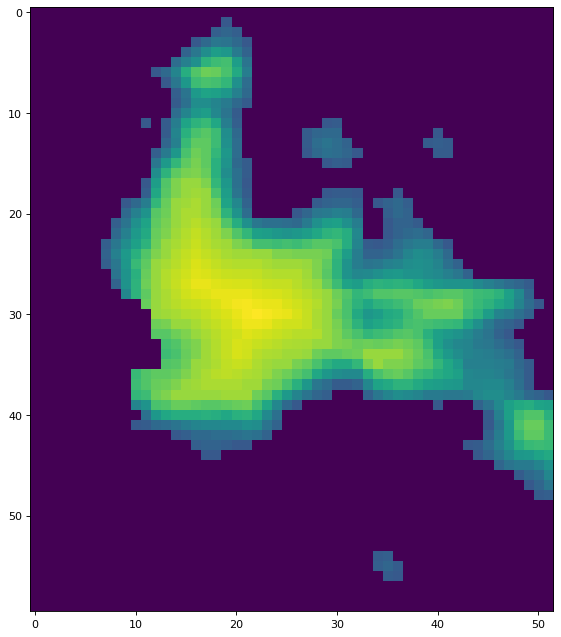

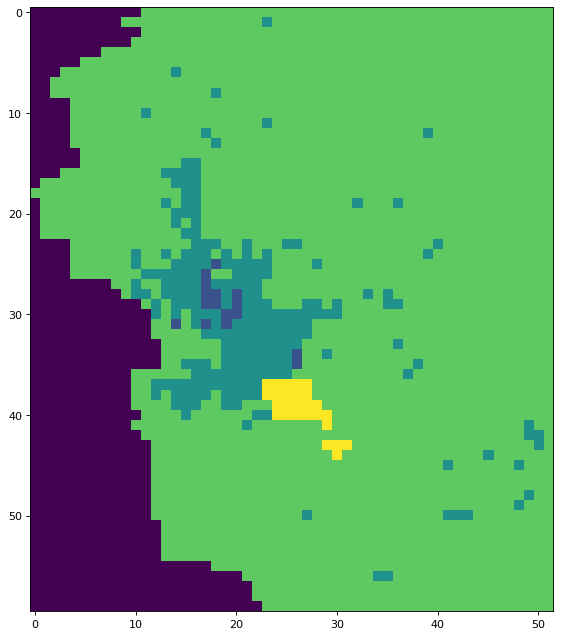

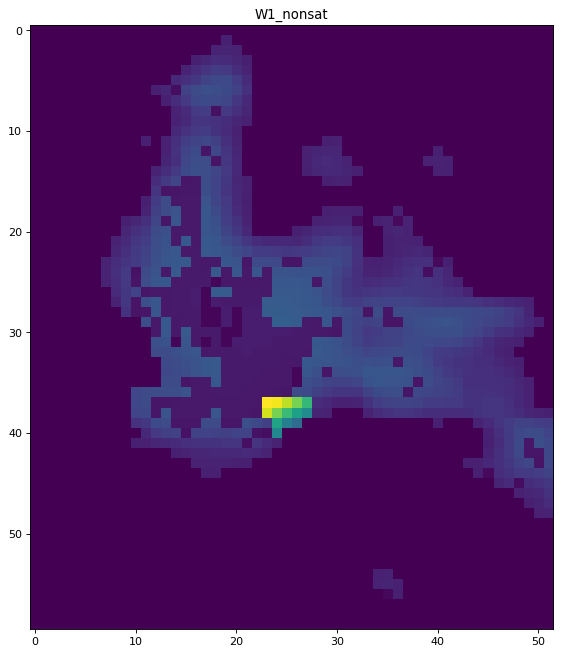

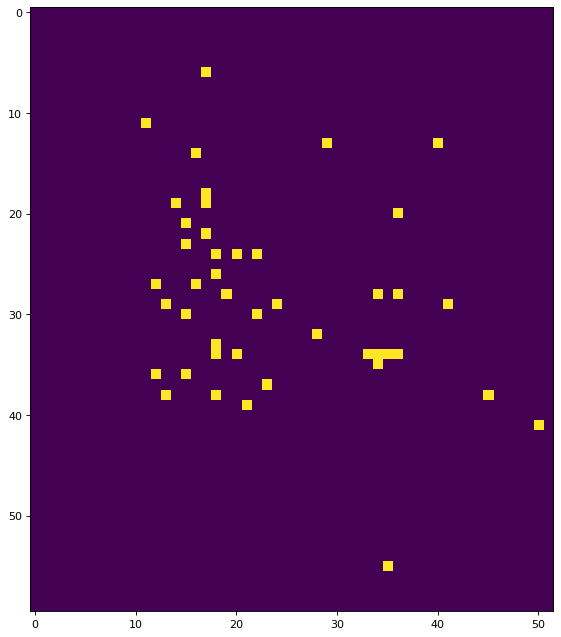

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

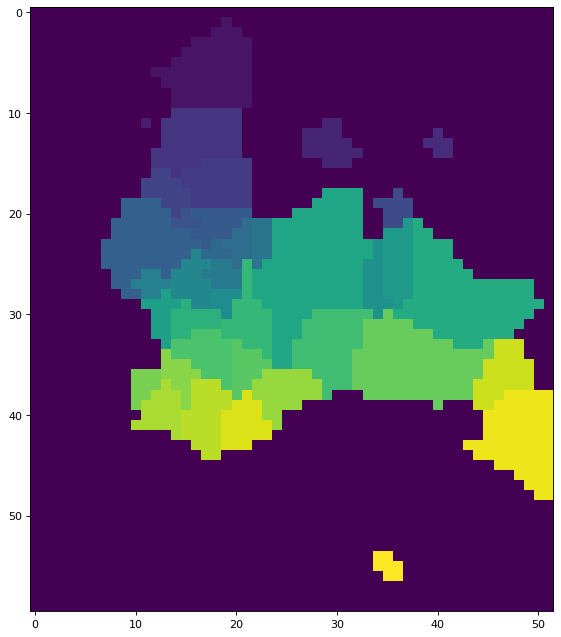

In [88]:
figure(figsize=(10, 10), dpi=80)
plt.imshow(nonsat)
plt.show()

figure(figsize=(10, 10), dpi=80)
plt.imshow(P)
plt.show()

figure(figsize=(10, 10), dpi=80)
W1_nonsat = f5(nonsat,P)
plt.title("W1_nonsat")
plt.imshow(W1_nonsat)
plt.show()

figure(figsize=(10, 10), dpi=80)
seeds = getMax(W1_nonsat)
plt.imshow(seeds)
plt.show()

figure(figsize=(10, 10), dpi=80)
coords = get_coords(seeds)

figure(figsize=(10, 10), dpi=80)
mask = np.zeros(W1_nonsat.shape, dtype=bool)
mask[tuple(coords.T)] = True

figure(figsize=(10, 10), dpi=80)
markers, _ = ndi.label(mask)
labels = watershed(-W1_nonsat, markers, mask=W1_nonsat)
plt.imshow(labels)
plt.show()


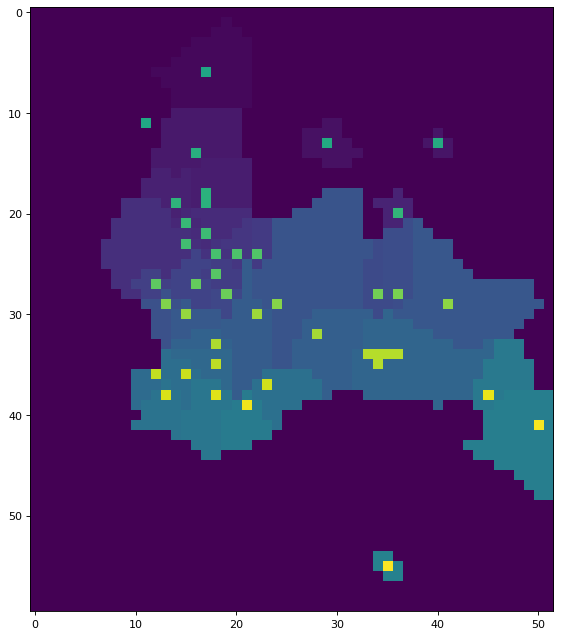

In [70]:
figure(figsize=(10, 10), dpi=80)
plt.imshow(labels+seeds*50)

# Ideas

1) Podemos descomponer la imagenen en polígonos convexos (convex hull) *no necesariamente convexos* .

2) Cada polígono representaría una aproximación de la contaminación lumínica en una región dado por un sensor. (Por ejemplo este puede ser el valor maximo de intensidad registrada en la región)

3) Podríamos variar el numero de polígonos para controlar el detalle de la aproximación.

4) El número de polígonos podría estar en función del número de sensores. 

5) Para priorizar localiacion de sensores, ademas de considerar: 

1) la intensidad de la luz  
2) La clase a la que perteneces la región  

Considerar:  
3) la extensión que la medición de este sensor representaría.
    
Por ejemplo, si hay dos sensores con la misma "calificación" desempatar con la región que este representa. Pondríamos un sensor en el polígono mas grande, aunque este tenga la misma intensidad y misma clase.
    
    